## Make some 4P4Z model validation figs 

### JRA forcing, x1 "005"

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
# import seawater as ?sw
# from seawater.library import T90conv
from scipy import stats
from cartopy.util import add_cyclic_point
from IPython.display import Image
import pop_tools

### Get the CESM data

In [2]:
start_yr = 51
num_years = 10
endyr = start_yr + num_years 
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005'
user = 'kristenk'

In [3]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/scratch/{user}/archive/{case}/ocn/hist/{case}.pop.h.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 51 !
doing simulation year 52 !
doing simulation year 53 !
doing simulation year 54 !
doing simulation year 55 !
doing simulation year 56 !
doing simulation year 57 !
doing simulation year 58 !
doing simulation year 59 !
doing simulation year 60 !


In [4]:
cesm_mon_ds=xr.open_mfdataset(files,decode_times=False,decode_coords=False, concat_dim='time')

### Keep only the variables we need

In [5]:
variables = ['photoC_TOT_zint','photoC_sp_zint',
             'photoC_diat_zint','photoC_diaz_zint','photoC_cocco_zint',
             'diatC', 'coccoC','spC','diazC',
            'zoo1C','zoo2C','zoo3C','zoo4C','x_graze_zoo1_zint','x_graze_zoo2_zint',
            'x_graze_zoo3_zint','x_graze_zoo4_zint'] 
coords = {'x':'TLONG','y':'TLAT'}

In [6]:
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
cesm_mon_ds = cesm_mon_ds.drop([v for v in cesm_mon_ds.variables if v not in keep_vars])

In [7]:
cesm_ann_ds=cesm_mon_ds.mean(dim='time')

#### get POP grid

In [8]:
grid = pop_tools.get_grid('POP_gx1v7')
lons=grid.TLONG
lats=grid.TLAT
area=grid.TAREA
depths=grid.z_t * 0.01
area_m=area * 1.e-4
dz_m=grid.dz * 0.01

#### plotting function

In [9]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

#### globally integrated zooplankton biomass

In [10]:
zoo1_biomass= esmlab.weighted_sum(cesm_ann_ds.zoo1C, weights=area_m, dim=['nlat', 'nlon']).compute() #mmol/m
zoo1_biomass = zoo1_biomass * 10. #mmol
zoo1_biomass = zoo1_biomass.sum(dim='z_t_150m')
zoo1_biomass = zoo1_biomass.values * 0.001* 1.e-15 * 12.011 #Pg
print('zoo1 biomass is ', zoo1_biomass, ' Pg C.')
zoo2_biomass= esmlab.weighted_sum(cesm_ann_ds.zoo2C, weights=area_m, dim=['nlat', 'nlon']).compute() #mmol/m
zoo2_biomass = zoo2_biomass * 10. #mmol
zoo2_biomass = zoo2_biomass.sum(dim='z_t_150m')
zoo2_biomass = zoo2_biomass.values * 0.001* 1.e-15 * 12.011 #Pg
print('zoo2 biomass is ', zoo2_biomass, ' PgC')
print('Total microzooplankton biomass is estimated at 0.24 Pg C (Buitenhuis et al., 2010). Here it is ', zoo1_biomass + zoo2_biomass, ' Pg C.')
zoo3_biomass= esmlab.weighted_sum(cesm_ann_ds.zoo3C, weights=area_m, dim=['nlat', 'nlon']).compute() #mmol/m
zoo3_biomass = zoo3_biomass * 10. #mmol
zoo3_biomass = zoo3_biomass.sum(dim='z_t_150m')
zoo3_biomass = zoo3_biomass.values * 0.001* 1.e-15 * 12.011 #Pg
print('zoo3 biomass is ', zoo3_biomass, ' Pg C. Mesozooplankton biomass is estimated to be between 0.16 to 0.19 Pg C (Buitenhuis et al., 2006; Moriarty & OBrien, 2013)')
zoo4_biomass= esmlab.weighted_sum(cesm_ann_ds.zoo4C, weights=area_m, dim=['nlat', 'nlon']).compute() #mmol/m
zoo4_biomass = zoo4_biomass * 10. #mmol
zoo4_biomass = zoo4_biomass.sum(dim='z_t_150m')
zoo4_biomass = zoo4_biomass.values * 0.001* 1.e-15 * 12.011 #Pg
print('zoo4 biomass is ', zoo4_biomass, ' Pg C. Macrozooplankton biomass is estimated to be 0.02 Pg C (Moriarty et al., 2013).')

zoo1 biomass is  0.12777372303799708  Pg C.
zoo2 biomass is  0.21926685998590323  PgC
Total microzooplankton biomass is estimated at 0.24 Pg C (Buitenhuis et al., 2010). Here it is  0.3470405830239003  Pg C.
zoo3 biomass is  0.33768332615133434  Pg C. Mesozooplankton biomass is estimated to be between 0.16 to 0.19 Pg C (Buitenhuis et al., 2006; Moriarty & OBrien, 2013)
zoo4 biomass is  0.20634768956645966  Pg C. Macrozooplankton biomass is estimated to be 0.02 Pg C (Moriarty et al., 2013).


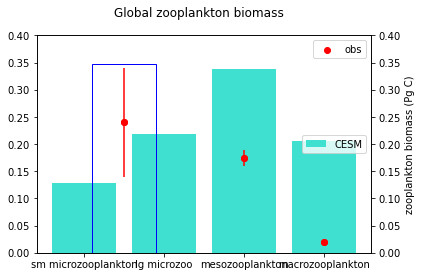

In [11]:
fig, ax = plt.subplots()
labels=['sm microzooplankton','lg microzoo','mesozooplankton','macrozooplankton']
ind=[0,1,2,3]
ind2=[0.5,2,3]
obs=[0.24,0.175,0.02]
obserr=[0.1,0.015,0]
vals=[zoo1_biomass,zoo2_biomass,zoo3_biomass,zoo4_biomass]

plt.suptitle('Global zooplankton biomass')
ax.bar(ind, vals,label='CESM',color='turquoise')
ax.bar(0.5,zoo1_biomass+zoo2_biomass,edgecolor='blue',fill=False)
ax.legend(loc='center right')
ax.set_ylim(0,0.4)
ax2 = ax.twinx()
ax2.scatter(ind2, obs,color='red',marker='o', label='obs')
ax2.errorbar(ind2, obs,yerr=obserr,color='red',fmt='o')
ax2.set_ylim(0,0.4)
ax2.set_ylabel('zooplankton biomass (Pg C)')
ax2.legend()
plt.xticks(ind, labels,rotation=45, ha='right');

### NPP

In [12]:
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

In [13]:
variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'cocco', 'TOT']]

ds_glb = xr.Dataset()
for v in variables:
    ds_glb[v] = esmlab.statistics.weighted_sum(cesm_ann_ds[v], weights=area, dim=['nlat', 'nlon'])
    ds_glb[v].attrs = cesm_ann_ds[v].attrs

    #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_glb = ds_glb.compute()
ds_glb

<xarray.Dataset>
Dimensions:            ()
Data variables:
    photoC_diat_zint   float64 20.69
    photoC_sp_zint     float64 34.31
    photoC_diaz_zint   float64 1.212
    photoC_cocco_zint  float64 2.184
    photoC_TOT_zint    float64 58.39

In [14]:
npp_file = '/glade/work/kristenk/satellite_data/NPP/MODIS_annNPP_3methodmean_2003-2017_9km.nc'
ds_npp = xr.open_dataset(npp_file, decode_times=False)
#units are g C/m2/y
ds_npp = ds_npp.mean(dim='time')

In [15]:
ds_npp

<xarray.Dataset>
Dimensions:  (lat: 1080, lon: 2160)
Coordinates:
  * lon      (lon) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.8 179.9
  * lat      (lat) float64 -89.92 -89.75 -89.58 -89.42 ... 89.58 89.75 89.92
Data variables:
    NPP      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [16]:
#convert from mmol/m3 cm/s to gC/m2/y
cesm_npp = cesm_ann_ds.photoC_TOT_zint * 0.01 * 86400. * 365 * 0.001 * 12.011

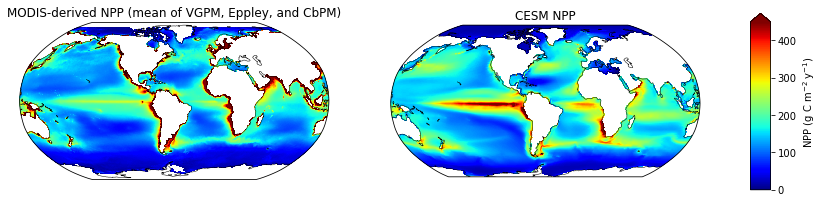

In [17]:
fig = plt.figure(figsize=(14,3.5))


ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('MODIS-derived NPP (mean of VGPM, Eppley, and CbPM)', fontsize=12)
ax.coastlines('110m',linewidth=0.5)
pc=ax.pcolormesh(ds_npp.lon.values, ds_npp.lat.values, ds_npp.NPP, cmap='jet',
                 vmin=0,vmax=450,
                 transform=ccrs.PlateCarree())

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM NPP', fontsize=12)
ax.coastlines('110m',linewidth=0.5)
lon, lat, field = adjust_pop_grid(lons, lats, cesm_npp)

pc=ax.pcolormesh(lon, lat, field, cmap='jet',
                 vmin=0,vmax=450,
                 transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='NPP (g C m$^{-2}$ y$^{-1}$)')

fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/NPP_comparison.png',dpi=300, boundingbox='tight')

### Zooplankton production (zoo grazing - zoo respiration)
#### Should be ~25% of NPP

In [18]:
variables = [f'x_graze_{zoo}_zint' for zoo in ['zoo1', 'zoo2', 'zoo3','zoo4']]

ds_zooglb = xr.Dataset()
for v in variables:
    ds_zooglb[v] = esmlab.statistics.weighted_sum(cesm_ann_ds[v], weights=area, dim=['nlat', 'nlon'])
    ds_zooglb[v].attrs = cesm_ann_ds[v].attrs

    #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
    ds_zooglb[v] = ds_zooglb[v] * nmols_to_PgCyr        
    ds_zooglb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_zooglb = ds_zooglb.compute()
ds_zooglb

<xarray.Dataset>
Dimensions:            ()
Data variables:
    x_graze_zoo1_zint  float64 7.657
    x_graze_zoo2_zint  float64 3.263
    x_graze_zoo3_zint  float64 3.353
    x_graze_zoo4_zint  float64 0.4385

In [19]:
## calculate % zoo prod of NPP 
npp_tot=ds_glb.photoC_TOT_zint.values
zoo_prod=ds_zooglb.x_graze_zoo1_zint.values + ds_zooglb.x_graze_zoo2_zint.values + ds_zooglb.x_graze_zoo3_zint.values
print('• Zooplankton production is ', (zoo_prod/npp_tot * 100.), '% of NPP.')
## calculate % microzooplankton (zoo1) prod of total zoo prod
micro_prod=ds_zooglb.x_graze_zoo1_zint.values
print('• Small microzooplankton production is ', (micro_prod/zoo_prod * 100.), '% of total zooplankton production.')
micro_prod=ds_zooglb.x_graze_zoo1_zint.values + ds_zooglb.x_graze_zoo2_zint.values
print('• Microzooplankton production is ', (micro_prod/zoo_prod * 100.), '% of total zooplankton production.')
print('• Microzooplankton production is ', (micro_prod/npp_tot * 100.), '% of NPP.')

• Zooplankton production is  24.441578183795233 % of NPP.
• Small microzooplankton production is  53.65111475557751 % of total zooplankton production.
• Microzooplankton production is  76.5108276734837 % of total zooplankton production.
• Microzooplankton production is  18.700453764883356 % of NPP.


### Z-ratio (Stock & Dunne, 2010)

In [20]:
file='/glade/work/kristenk/z-ratio/z_ratio_POPgrid.nc'
ds_zratio=xr.open_dataset(file,decode_times=False,decode_coords=False)

In [21]:
#z_ratio = cesm_ann_ds.x_graze_zoo3_zint / cesm_ann_ds.photoC_TOT_zint
z_ratio = (cesm_ann_ds.x_graze_zoo3_zint + cesm_ann_ds.x_graze_zoo4_zint) / cesm_ann_ds.photoC_TOT_zint

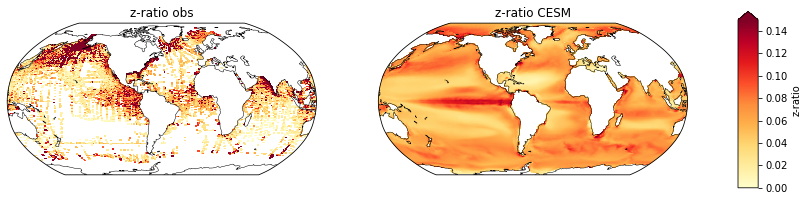

In [22]:
fig = plt.figure(figsize=(14,3.5))

lon, lat, field = adjust_pop_grid(lons, lats, ds_zratio.z_ratio)

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('z-ratio obs', fontsize=12)
pc=ax.pcolormesh(lon, lat, field, cmap='YlOrRd',vmin=0,vmax=0.15,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = adjust_pop_grid(lons, lats, z_ratio)

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('z-ratio CESM', fontsize=12)
pc=ax.pcolormesh(lon, lat, field, cmap='YlOrRd',vmin=0,vmax=0.15,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='z-ratio')

fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/z_ratio_comparison.png',dpi=300, boundingbox='tight')

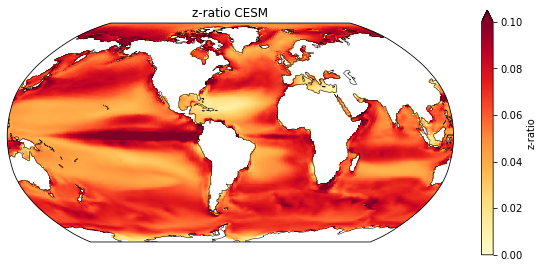

In [26]:
fig = plt.figure(figsize=(10,4.5))

lon, lat, field = adjust_pop_grid(lons, lats, z_ratio)

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('z-ratio CESM', fontsize=12)
pc=ax.pcolormesh(lon, lat, field, cmap='YlOrRd',vmin=0,vmax=0.1,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
fig.colorbar(pc,extend='max', label='z-ratio')
fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/z_ratio_CESM.png',dpi=300, boundingbox='tight')

### COPEPOD comparison (Mesozooplankton/zoo3)

In [35]:
file = '/glade/u/home/kristenk/work/copepod-biomass/data/POP_gx1v7/copepod-2012__cmass-m00-qtr.zarr'
ds_copepod = xr.open_zarr(file)
ds_copepod['copepod_C']=ds_copepod.copepod_C/12.011

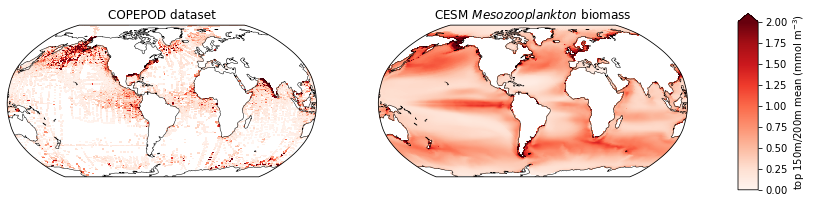

In [45]:
fig = plt.figure(figsize=(14,3.5))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('COPEPOD dataset', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, ds_copepod.copepod_C)
pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)


ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM ${\it Mesozooplankton}$ biomass', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, cesm_ann_ds.zoo3C.mean(dim='z_t_150m'))
pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='top 150m/200m mean (mmol m$^{-3}$)')

fig.savefig('/glade/u/home/kristenk/adding_zooplankton/MARBL_4p4z/images/copepod_comparison.png',dpi=300, boundingbox='tight')

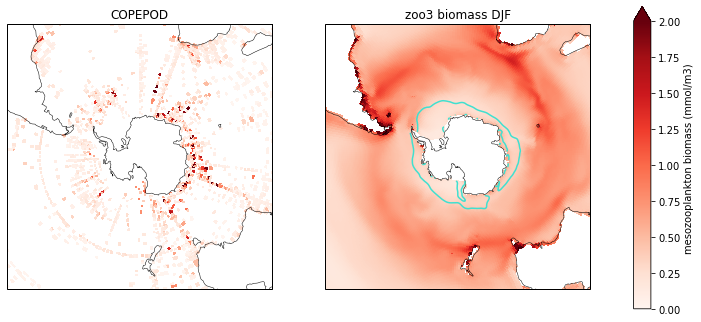

In [57]:
fig = plt.figure(figsize=(12,6))

# obs -----------------------------------------------------------------
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
ax.set_title('COPEPOD')
tmp = ds_copepod.copepod_C
lon,lat,field = adjust_pop_grid(lons, lats, tmp)

sh = lats[:, 0] < 0
lons_sh = lon[sh, :]
lats_sh = lat[sh, :]
field = field[sh, :]
pc=ax.pcolormesh(lons_sh, lats_sh, field, #converting from mg/m3 to mmol/m3
                 vmin=0, vmax=2, 
                 cmap='Reds',
                 transform=ccrs.PlateCarree())

########################
tmp = cesm_ann_ds.zoo3C.mean(dim='z_t_150m')
lon,lat,field = adjust_pop_grid(lons, lats, tmp)

sh = lats[:, 0] < 0
lons_sh = lon[sh, :]
lats_sh = lat[sh, :]
field = field[sh, :]

lon,lat,field2 = adjust_pop_grid(lons, lats, ifrac)
lons_sh2 = lon[sh, :]
lats_sh2 = lat[sh, :]
field2 = field2[sh, :]

ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('zoo3 biomass DJF', fontsize=12)
pc=ax.pcolormesh(lons_sh, lats_sh, 
                 field, 
                 vmin=0, vmax=2, 
                 cmap='Reds',
                 transform=ccrs.PlateCarree())
pci=ax.contour(lons_sh2, lats_sh2, 
                 field2, 
                 levels=[0.1], 
                 colors='turquoise',
                 transform=ccrs.PlateCarree(), label='10% ice cover'
              )

ax.coastlines('110m',linewidth=0.5)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='mesozooplankton biomass (mmol/m3)');
# cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
# fig.colorbar(pci, cax=cbar_ax,extend='max', label='IFRAC');

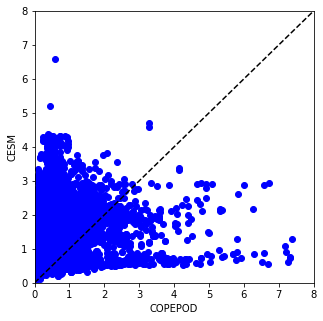

In [58]:
#### make line plots plotting mesozooplankton abundance versus COPEPOD database
one2one = np.array([0, 8])
x_vals = ds_copepod.copepod_C.values
x_vals = x_vals.flatten()

fig = plt.figure(figsize=(5,5))   
#set up the vals
y_vals = cesm_ann_ds.zoo3C.isel(z_t_150m=0).values
y_vals = y_vals.flatten()
ax = fig.add_subplot(1,1,1)
ax.scatter(x_vals,y_vals,color='blue',marker='o',
           label='control')
ax.set_ylabel('CESM')
ax.set_xlabel('COPEPOD')
ax.set_ylim(0,8)
ax.set_xlim(0,8)
ax.plot(one2one,one2one,color='black',linestyle='--')

### Macrozooplankton comparison

In [37]:
file = '/glade/work/kristenk/MAREDAT/macrozooplankton/mean_fields/MAREDAT_macrozoo_means.nc'
maredat_macrozoo_ds=xr.open_dataset(file,decode_times=False,decode_coords=False)

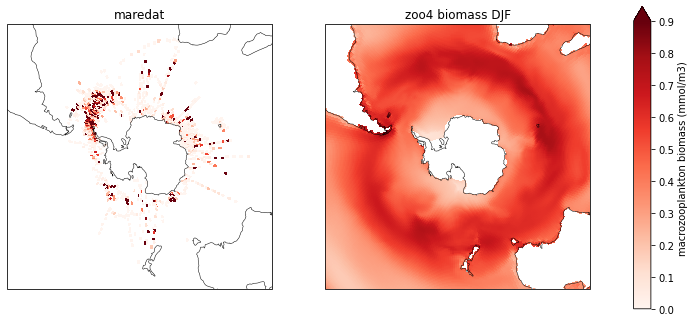

In [38]:
fig = plt.figure(figsize=(12,6))
max_val=0.9


# obs -----------------------------------------------------------------
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.coastlines('110m',linewidth=0.5)
ax.set_title('maredat')
pc=ax.pcolormesh(maredat_macrozoo_ds.LONGITUDE, maredat_macrozoo_ds.LATITUDE, 
                 maredat_macrozoo_ds.DJF_mean_top100m/12.011, #converting from mg/m3 to mmol/m3
                 vmin=0, vmax=max_val, 
                 cmap='Reds',
                 transform=ccrs.PlateCarree())

########################
tmp = cesm_mon_ds.zoo4C.isel(time=[11,0,1],z_t_150m=slice(0,10)).mean(dim='z_t_150m').mean(dim='time')
lon,lat,field = adjust_pop_grid(lons, lats, tmp)

sh = lats[:, 0] < 0
lons_sh = lon[sh, :]
lats_sh = lat[sh, :]
field = field[sh, :]


ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
ax.set_title('zoo4 biomass DJF', fontsize=12)
pc=ax.pcolormesh(lons_sh, lats_sh, 
                 field, 
                 vmin=0, vmax=max_val, 
                 cmap='Reds',
                 transform=ccrs.PlateCarree())


ax.coastlines('110m',linewidth=0.5)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='macrozooplankton biomass (mmol/m3)')